# Sheep Counting Using Object Detection and ByteTrack

## Overview

This Jupyter Notebook provides a practical solution for counting sheep in video footage using advanced object detection and tracking technologies. Inspired by the techniques and resources from the `supervision` GitHub repository, the notebook outlines a step-by-step approach to load a pre-trained model for object detection, evaluate its performance, and then track and count sheep as they pass a virtual line using ByteTrack. The notebook is an application of the tutorial [Count Objects Crossing the Line](https://supervision.roboflow.com/develop/notebooks/count-objects-crossing-the-line/) from Supervision.

The primary objectives of this notebook are:

1. **Loading and Deploying an Object Detection Model**: We will begin by loading a pre-trained deep learning model capable of detecting sheep in video frames. Models such as YOLO (You Only Look Once) are particularly suited for this task due to their real-time detection capabilities and high accuracy.

2. **Evaluating Model Performance on Video**: After loading the detection model, we will apply it to a sample video of a flock of sheep. This step involves processing each frame to identify and classify sheep, allowing us to evaluate the model's effectiveness in detecting sheep accurately under various conditions.

3. **Tracking Sheep with ByteTrack**: Once sheep are detected, we will use ByteTrack to follow each sheep across frames. ByteTrack is designed to maintain tracking of objects even in crowded or occluded scenarios, ensuring consistent identification and tracking of each sheep.

4. **Counting Sheep Crossing a Virtual Line**: Finally, we will set up a virtual line in the video frame and count how many sheep cross this line. 

## Implementation Steps

1. **Model Loading and Initialization**:
   - Import necessary libraries and modules.
   - Load a sample video featuring a flock of sheep.
   - Load a pre-trained object detection model tailored for detecting sheep.

2. **Video Processing and Object Detection**:
   - Apply the object detection model to each frame to identify sheep.
   - Visualize the detection results with bounding boxes around each sheep.

3. **Integrating ByteTrack for Object Tracking and Sheep Counting Using a Virtual Line**:
   - Initialize ByteTrack.
   - Define the position of a virtual line within the video frame.
   - Display the tracking results on the video, showing the movement paths and IDs of each sheep.
   - Count tracking sheeps as they cross the line.
   - Display the count results and visualize crossing events on the video output.

By the end of this notebook, you will have developed a system capable of accurately detecting, tracking, and counting sheep using advanced deep learning and tracking technologies.

## 1. **Model Loading and Initialization**:

In [1]:
import os
import numpy as np
import supervision as sv
from ultralytics import YOLO

### Define directories

In [2]:
HOME = os.getcwd()
print(HOME)

c:\Users\helary_l\Documents\ICAERUS\code\scripts_utiles\track


In [3]:
import os
VIDEO_PATH = "path/to/your/videos"
print(VIDEO_PATH)

c:/Users/helary_l/Documents/ICAERUS/Images_drone/Sheep_drone_images/travail/test/cropped_videos


### Load video file

In [4]:
FILE = "video.mp4"
SOURCE_VIDEO_PATH = f"{VIDEO_PATH}/{FILE}"

In [5]:
print(SOURCE_VIDEO_PATH)

c:/Users/helary_l/Documents/ICAERUS/Images_drone/Sheep_drone_images/travail/test/cropped_videos/crop_Passage_brebis_portique_UHF_9.MP4


### Define export folder

In [6]:
EXPORT = 'path_to_export_folder'

In [7]:
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_info

VideoInfo(width=1440, height=1080, fps=9, total_frames=495)

### Load pre-trained model

In [8]:
# settings
SHEEP_MODEL = f"{HOME}/path_to_detector/model.pt"

In [9]:
from ultralytics import YOLO

model = YOLO(SHEEP_MODEL)
model.fuse()

Model summary (fused): 218 layers, 25840339 parameters, 0 gradients


## 2. **Video Processing and Object Detection**:


In [10]:
%cd {HOME}
!yolo task=detect mode=predict model="path/to/detector.pt" conf=0.50 source={SOURCE_VIDEO_PATH}

c:\Users\helary_l\Documents\ICAERUS\code\scripts_utiles\track


create a video generator for our sample input file and display its first frame on the screen

In [10]:
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

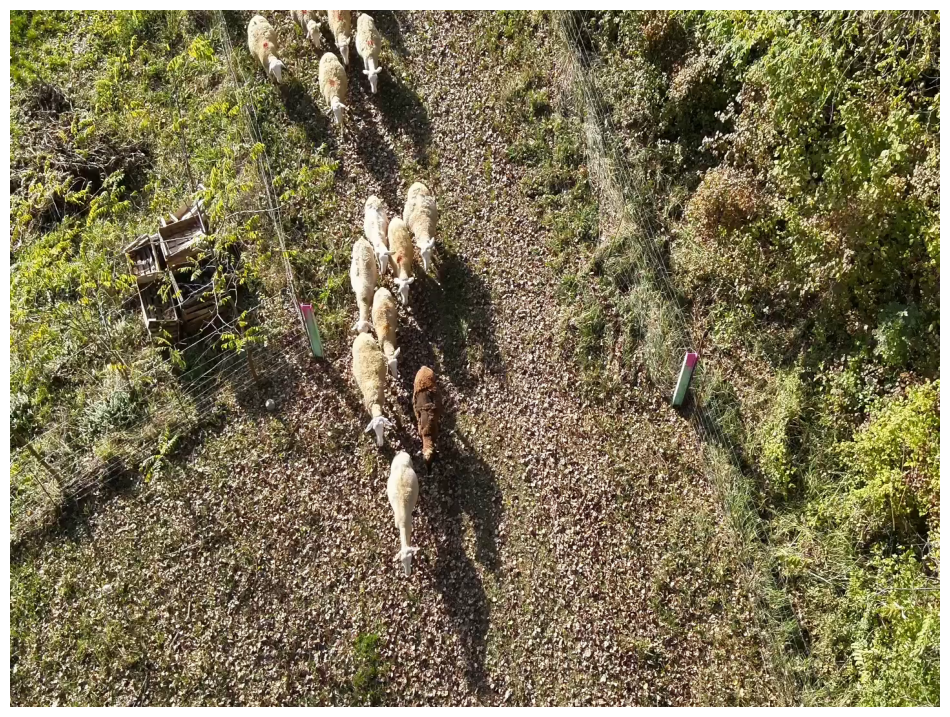

In [ ]:
frame = next(generator)

sv.plot_image(frame, (12, 12))

In [ ]:
#### run object detection on one frame

results = model(frame, verbose = False)[0]
detections = sv.Detections.from_ultralytics(results)

## 3. **Integrating ByteTrack for Object Tracking and Sheep Counting Using a Virtual Line**:
### Define the position of the virtual line

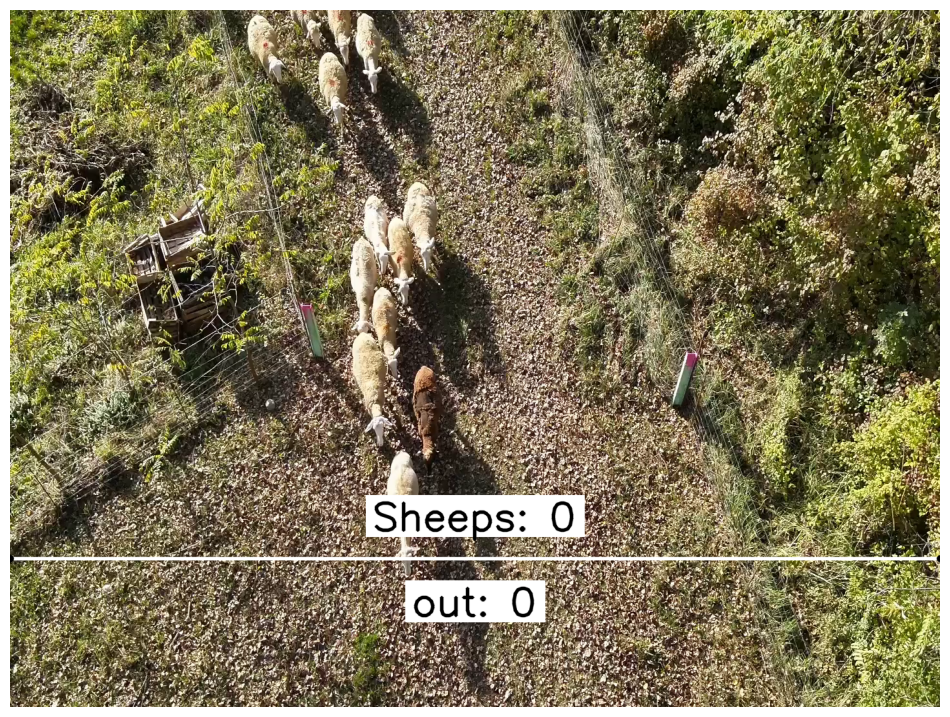

In [13]:
# line drawing
START = sv.Point(0, 850)
END = sv.Point(1440, 850)

# define line zone
line_zone = sv.LineZone(start=START, end=END)

line_zone_annotator = sv.LineZoneAnnotator(
    thickness=4,
    text_thickness=4,
    text_scale=2,
    custom_in_text="Sheeps"
    )

annotated_frame = frame.copy()
annotated_frame = line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

# show line annotator on one frame
sv.plot_image(annotated_frame, (12, 12))

#### Improve vizualization

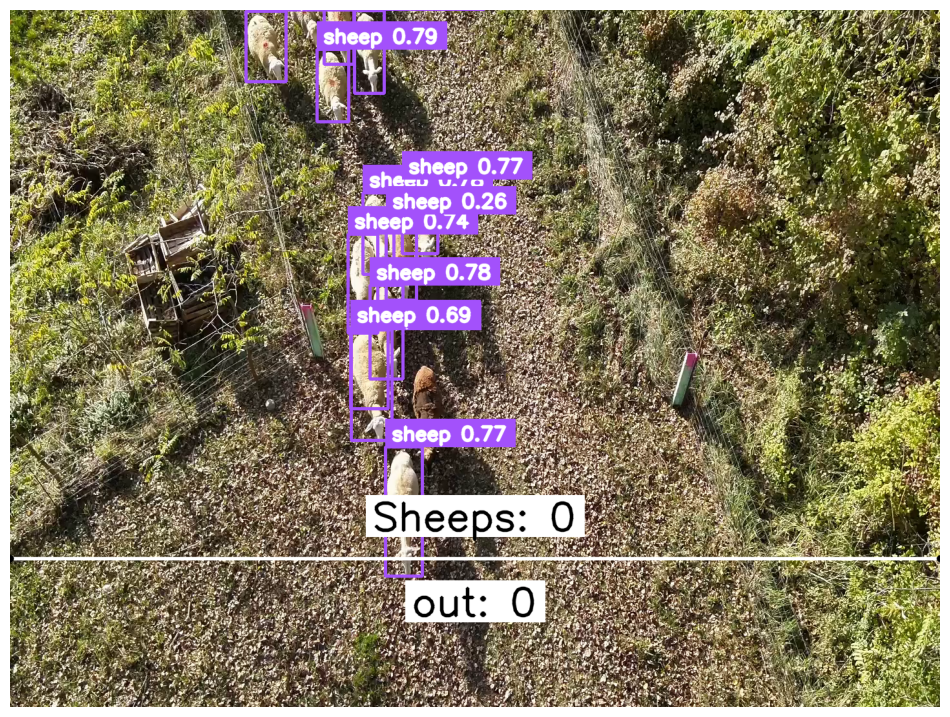

In [16]:
# define labels to show on each bounding box
labels = [
    f'{results.names[class_id]} {confidence:0.2f}'
    for class_id, confidence 
    in zip(detections.class_id, detections.confidence)
]

# add bounding box annotator
bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=4, text_scale=1)
trace_annotator = sv.TraceAnnotator(thickness=4)

annotated_frame = frame.copy()
annotated_frame = bounding_box_annotator.annotate(annotated_frame, detections)
annotated_frame = label_annotator.annotate(annotated_frame, detections, labels)
annotated_frame = line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

# show the results on one frame
sv.plot_image(annotated_frame, (12, 12))

#### Process video

In [15]:
# call for ByteTrack algorithm
byte_tracker = sv.ByteTrack()

In [17]:
# All the operations we plan to perform for each frame of our video 
# - detection, tracking, annotation, and counting - are encapsulated in a function named callback.

def callback(frame: np.ndarray, index:int) -> np.ndarray:
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = byte_tracker.update_with_detections(detections)

    labels = [f"#{tracker_id} {confidence:0.2f}"
        for confidence, tracker_id 
        in zip(detections.confidence,detections.tracker_id)
    ]

    annotated_frame = frame.copy()
    annotated_frame = trace_annotator.annotate(
        scene=annotated_frame,
        detections=detections)
    annotated_frame = bounding_box_annotator.annotate(
        scene=annotated_frame,
        detections=detections)
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame,
        detections=detections,
        labels=labels)

    line_zone.trigger(detections)
    return  line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)


In [18]:
# define export video name
TARGET_VIDEO_PATH = f"{EXPORT}/name_ouf_export_file.mp4"
print(TARGET_VIDEO_PATH)

c:/Users/helary_l/Documents/ICAERUS/Images_drone/Sheep_drone_images/travail/test/analyses/tracking/line_best_sheep_crop_23.11.23-10_test.mp4


In [19]:
# process video
sv.process_video(
    source_path = SOURCE_VIDEO_PATH,
    target_path = TARGET_VIDEO_PATH,
    callback=callback
)